In [1]:
from astropy.table import Table, Column
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm          
sys.path.insert(0, '../Modules')
import erqMedSpec 
import erqScaling
from line_db import line_db
import os
from scipy import interpolate
from scipy.io import loadmat
from scipy import interpolate
from readSDSSspectrafast import *
from scipy import ndimage
from matplotlib import cm
# Reading data
# smp=Table.read('/home/reza/erq/sampling/org_sample2.fits')
smp=Table.read('../LumMatch/LumMatch.fits')
W3_0=smp['ABw3']
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
z_dr12=smp['z_dr12']
plate = smp['Plate']
mjd = smp['MJD']
fiberid= smp['FiberID']
iz_0 = iW3_0 - smp['r-w3'] + smp['r-z']
Lum_0 = smp['Lum']
np.savetxt('../IsoSurf/data3d.dat', np.array(list(zip(iW3_0, rew_0, kt80_0))))
BI_c4 = smp['bal_flag_vi']
# counting number of boxy T1ERQs from simple cuts
np.sum((iW3_0>=4.6) & (rew_0>=2) & (kt80_0>=0.33))

52

In [2]:
# loading label from MATLAB binned labels 
dir = '3D-Analysis/'
# loading labels from Matlab code
labels = loadmat('../IsoSurf/labels.mat')
labels= np.array(labels["labels"])
bin_label=labels[0]
data_0=np.array(list(zip(iW3_0, rew_0, kt80_0)))
(data, minData, rangeData) =  erqScaling.MinMaxScaler(data_0)

nBins = np.int32(max(bin_label))
bin_pop = np.zeros([nBins])
nBin = np.int32(np.max(labels))
if os.path.exists(dir)==False:
    os.system('mkdir -p ' + dir)
    

In [3]:
nBin

7

In [39]:
# median spectra  in 3D
for b in range(1,nBin):
    mask = (bin_label==b+1)
    medSpec = erqMedSpec.stacker(z_dr12[mask], plate[mask], mjd[mask], fiberid[mask])
    np.savetxt(dir +'med-spec-bin-%d.txt' %b, medSpec)

100%|██████████| 386/386 [00:38<00:00, 10.05it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|██████████| 23/23 [00:02<00:00, 10.14it/s]


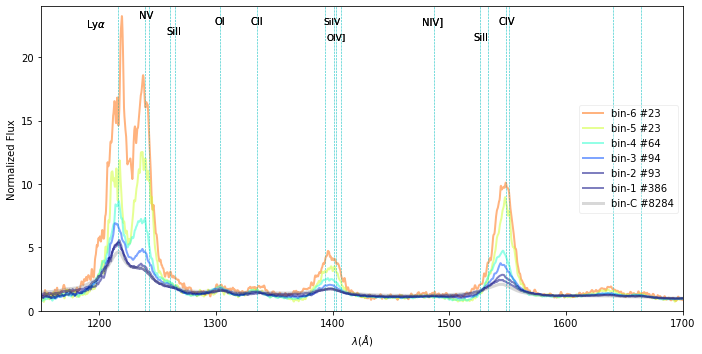

In [3]:
# plotting median spectra 
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nqsos = len(z_dr12)
cone_direction=0
nqsos = len(z_dr12)
bin_pop = np.zeros([nBin])
for b in range(1,nBin+1):
    bin_pop[b-1] = sum(bin_label==b)

ymax=24
ymin=-0.05*ymax
fs=10
fs1=9

y_median = 0.9*ymax
med_step=1
legend_loc=7
c = cm.get_cmap('jet', 6)
lambda_min = 1150; lambda_max = 1700
fig = plt.figure(figsize=(11.5,5.6))
line_db(ymax, fs, fs1, lambda_max)

plt.xlim(lambda_min,lambda_max)
plt.ylim(ymin, ymax)
for b in reversed(range(nBin)):
    if(bin_pop[b]>5):   
        med1=loadtxt(dir + '/med-spec-bin-%d.txt' %(b))
        plt.ylabel('Normalized Flux')
        plt.xlabel(r'$\lambda  (\AA)$')
        if(bin_pop[b]<100):
            sm_med1 = ndimage.filters.gaussian_filter1d(med1,2.0)
        else:
            sm_med1=med1
        # masking for plot ranges
        ind = (wgrid>lambda_min) & (wgrid<lambda_max)
        if b==0:
            plt.plot(wgrid[ind],  sm_med1[ind], lw = 3, alpha=0.3, c='grey', 
                     label='bin-C #%d' %bin_pop[b])
        else:
             plt.plot(wgrid[ind],  sm_med1[ind], lw = 2, c=c(b-2), 
                     label='bin-%d #%d' %(b, bin_pop[b]), alpha=0.5)
#            
plt.legend(fancybox=True, framealpha=0.3, loc=legend_loc)
line_db(ymax, fs, fs1, lambda_max)
fig_path = dir + '/3d-med-spec-%d-lf-%d.png' %(lambda_min,lambda_max)
plt.savefig(fig_path, format='png', dpi=400,  bbox_inches='tight')
plt.show()

In [4]:
! cp 3D-Analysis/3d-med-spec-1150-lf-1700.png ../../erqPaper/fig

In [20]:
# Table of properties 
imw3_bin_med =[]
REW_bin_med = []
fwhm_bin_med = []
kt80_bin_med = []
frat_bin_med = []
iz_bin_med = []
Lum_bin_med = []
# -----------------
imw3_bin_std =[]
REW_bin_std= []
fwhm_bin_std = []
kt80_bin_std = []
frat_bin_std = []
iz_bin_std = []
Lum_bin_std = []
Bin=[]
BinPop=[]
nBins=8
BAL=[]
for b in range(nBins):
    mask = (bin_label==b+1)
    BinPop.append(sum(mask))
    Bin.append("{0:.0f}".format(b+1))
    imw3_bin_med.append("{0:.2f}".format(np.median(iW3_0[mask==True])))
    REW_bin_med.append("{0:.0f}".format(np.median(10**(rew_0[mask==True]))))
    fwhm_bin_med.append("{0:.0f}".format(np.round(np.median(fwhm_0[mask==True])/100)*100))
    kt80_bin_med.append("{0:.2f}".format(np.median(kt80_0[mask==True])))
    frat_bin_med.append("{0:.2f}".format(np.median(frat_0[mask==True])))
    iz_bin_med.append("{0:.2f}".format(np.median(iz_0[mask==True])))
    Lum_bin_med.append("{0:.2f}".format(np.median(Lum_0[mask==True])))
    BAL.append("{0:.2f}".format(np.sum(BI_c4[mask])/np.sum(mask)))
    
    imw3_bin_std.append("{0:.2f}".format(np.std(iW3_0[mask==True])))
    REW_bin_std.append("{0:.0f}".format(np.std(10**(rew_0[mask==True]))))
    fwhm_bin_std.append("{0:.0f}".format(np.round(np.std(fwhm_0[mask==True])/100)*100))
    kt80_bin_std.append("{0:.2f}".format(np.std(kt80_0[mask==True])))
    frat_bin_std.append("{0:.2f}".format(np.std(frat_0[mask==True])))
    iz_bin_std.append("{0:.2f}".format(np.std(iz_0[mask==True])))
    Lum_bin_std.append("{0:.2f}".format(np.std(Lum_0[mask==True])))

tabProperties = Table([Bin,BinPop, imw3_bin_med, imw3_bin_std, REW_bin_med, REW_bin_std, 
                       fwhm_bin_med, fwhm_bin_std, kt80_bin_med, kt80_bin_std,
                       frat_bin_med, frat_bin_std, BAL,iz_bin_med, iz_bin_std, Lum_bin_med, Lum_bin_std],
                      names=('B','N', 'i-W3', 'i-W3_sigma' ,'REW', 'REW_sigma', 'FWHM', 'FWHM_sigma', 
                             'kt80', 'kt80_sigma', 'f', 'f_sigma', 'BAL', 'i-z', 'i-z_sigma', 'L', 'L_sigma'))
tabProperties.write(dir + '/3d-Properties.fits' , format='fits', overwrite=True)

/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3332: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-20-2252f97259bc>:32: RuntimeWarning: invalid value encountered in long_scalars
  BAL.append("{0:.2f}".format(np.sum(BI_c4[mask])/np.sum(mask)))
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret 

In [53]:
# # PDF of LOF in each bin for different k
# nBoot=100
# for k in [40,50, 100, 150]:
#     DistLOFMedian= np.zeros([nBoot,nBin])
#     for Boot in tqdm(range(nBoot)):
#         BootStrap = loadmat('../IsoSurf/SampleLabel/BootStrap-%d.mat'%(Boot+1))
#         bin_label= np.array(BootStrap["labels"])
#         bin_label= bin_label[0]
#         data_boot = np.array(BootStrap["X_boot"])
# #         data_boot = data_boot[0]
    
# #          LOF
#         clf= LOF(n_neighbors=k,  n_jobs=4)
#         clf.fit_predict(data_boot)
#         LOFScores= -clf.negative_outlier_factor_
#         for b in range(nBin):
#             mask = (bin_label==b+1)
#             DistLOFMedian[Boot,b] = np.median(LOFScores[mask])
#     np.savetxt('Dist3DLOFMedian-k-%d.dat'%k,DistLOFMedian)
   

In [ ]:
# finding best bins whch make the deapest dip in LOF in bin 4
max_diff = -100
for i in tqdm(range(-10,11)):
    for j in range(-10,11):
        for k in range(40, 100, 10):
            clf= LOF(n_neighbors=k,  n_jobs=8)
            clf.fit_predict(data)
            LOFScores= -clf.negative_outlier_factor_
           
            labels = loadmat('../IsoSurf/labels-%d-%d.mat'%(i,j))
            labels= np.array(labels["labels"])
            bin_label=labels[0]
            nBins = np.int32(max(bin_label))

            LOFScoresMed=np.zeros([nBins])
            #  Median properties in each bin
            for b in range(nBins):
                mask = (bin_label==b+1)
                LOFScoresMed[b] =np.median(LOFScores[mask])
            if ((LOFScoresMed[3]-LOFScoresMed[4])>max_diff):
                max_diff = LOFScoresMed[3]-LOFScoresMed[4]
                min_LOF_B3 = LOFScoresMed[3]
                max_LOF_B4 = LOFScoresMed[4]
                i_max=i
                j_max=j
                k_min = k
                plt.plot(['c','1', '2', '3', '4', '5', '6' ], LOFScoresMed, marker='o', 
                         label=r'B-3#%d B-4#%d B-k=%d i=%d j=%d $\Delta_{LOF}^{3-4}=%.3f$'%(np.sum(labels==4), np.sum(labels==5),
                                                        k, i,j, LOFScoresMed[3] - LOFScoresMed[4]), alpha=0.5)
                plt.legend()
                plt.show()

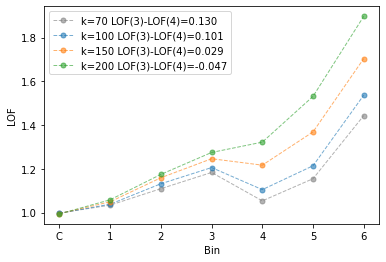

In [4]:
#plotting LOF medians  for different k 
dir ='3D-Analysis/'
i_max = -1
j_max = -5
labels_best = loadmat('../IsoSurf/labels-%d-%d.mat'%(i_max,j_max))
labels_best= np.array(labels_best["labels"])
bin_label_best=labels_best[0]
nBin = np.int32(max(bin_label_best))
c = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C6']
from scipy import stats 
from sklearn.neighbors import LocalOutlierFactor as LOF
cind=-1
for k in [70, 100, 150, 200]:
# for k in [30]:
    cind+=1
    clf= LOF(n_neighbors=k,  n_jobs=-1)
    clf.fit_predict(data)
    LOFScores= -clf.negative_outlier_factor_
    LOFScoreMedian=np.zeros([nBin])                       
    for b in range(nBin):
        mask = (bin_label_best==b+1)
        LOFScoreMedian[b] = np.median(LOFScores[mask])
    plt.plot(['C', '1', '2', '3', '4', '5', '6'], LOFScoreMedian, marker='o', lw=1, ls='--',
             markersize=5, alpha =0.6, c=c[cind], label =r'k=%d LOF(3)-LOF(4)=%.3f'%(k, LOFScoreMedian[3]-LOFScoreMedian[4]))                      

plt.legend()
plt.xlabel('Bin')
plt.ylabel('LOF')
plt.savefig(dir+'3d-LOF_Bin_best.png', dpi=200, format='png', bbox_inches='tight')
plt.show()

In [6]:
! cp 3D-Analysis/3d-LOF_Bin_best.png ../../erqPaper/fig


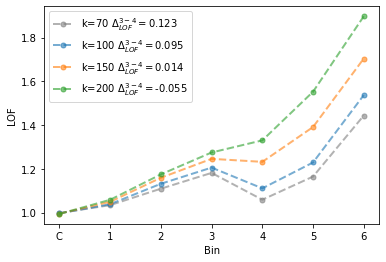

In [77]:
#plotting LOF medians  for different k 
labels_ini = loadmat('../IsoSurf/labels.mat')
labels_ini= np.array(labels_ini["labels"])
bin_label_ini=labels_ini[0]
nBin = np.int32(max(bin_label_ini))
c = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C6']
from scipy import stats 
from sklearn.neighbors import LocalOutlierFactor as LOF
cind=-1
for k in [70, 100, 150, 200]:
# for k in [30]:
    cind+=1
    clf= LOF(n_neighbors=k,  n_jobs=-1)
    clf.fit_predict(data)
    LOFScores= -clf.negative_outlier_factor_
    LOFScoreMedian=np.zeros([nBin])                       
    for b in range(nBin):
        mask = (bin_label_ini==b+1)
        LOFScoreMedian[b] = np.median(LOFScores[mask])
    plt.plot(['C', '1', '2', '3', '4', '5', '6'], LOFScoreMedian, marker='o', lw=2, ls='--',
             markersize=5, alpha =0.6, c=c[cind], label =r'k=%d $\Delta_{LOF}^{3-4}=$%.3f'%(k, LOFScoreMedian[3]-LOFScoreMedian[4]))                        

plt.legend()
plt.xlabel('Bin')
plt.ylabel('LOF')
plt.savefig(dir+'/3d-LOF_bin_ini.png', dpi=200, format='png')
plt.show()

In [79]:
! cp 3D-Analysis/3d-LOF_*.png ../../erqPaper/fig 

In [ ]:
# #plotting LOF medians and their CI for different k 
# labels = loadmat('../IsoSurf/labels.mat')
# labels= np.array(labels["labels"])
# bin_label=labels[0]
# nBin = np.int32(max(bin_label))
# c = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C6']
# from scipy import stats 
# from sklearn.neighbors import LocalOutlierFactor as LOF
# cind=-1
# for k in [40, 50, 100, 150]:
# # for k in [30]:
#     cind+=1
#     DistLOFMedian = np.loadtxt('Dist3DLOFMedian-k-%d.dat'%k)
#     clf= LOF(n_neighbors=k,  n_jobs=-1)
#     clf.fit_predict(data)
#     LOFScores= -clf.negative_outlier_factor_
#     LOFScoreMedian=np.zeros([nBin])                       
#     l = np.zeros([nBin])
#     u = np.zeros([nBin])
#     el = np.zeros([nBin])
#     eu = np.zeros([nBin])
#     meanLOF = np.zeros([nBin])
#     for b in range(nBin):
#         mean, var, std = stats.bayes_mvs(DistLOFMedian[:,b], alpha=0.99)
#         meanLOF[b] = mean[0]
#         l[b],u[b] = mean[1]
#         l[b]=meanLOF[b] - l[b] 
#         u[b]=u[b] - meanLOF[b]
#         mask = (bin_label==b+1)
        
           
#         LOFScoreMedian[b] = np.median(LOFScores[mask])

# #     plt.errorbar(['C', '1', '2', '3', '4', '5', '6'], LOFScoreMedian, 
# #                  yerr=e,marker='o', lw=2, ls='-',
# #              markersize=2, alpha =0.6, label='k=%d'%k, c=c[cind])                       
#     plt.errorbar(['C', '1', '2', '3', '4', '5', '6', '7'], LOFScoreMedian, 
#                  yerr=l, uplims=False, lolims=True ,marker='o', lw=1, ls='--',
#              markersize=2, alpha =0.6, label='k=%d'%k, c=c[cind])
#     plt.errorbar(['C', '1', '2', '3', '4', '5', '6', '7'], LOFScoreMedian, 
#                  yerr=u, lolims=False, uplims=True, marker='o', lw=1, ls='--',
#              markersize=2, alpha =0.6, c=c[cind])

# plt.legend()
# plt.xlabel('Bin')
# plt.ylabel('LOF')
# # plt.title('K=%d'%k)
# plt.savefig(dir+'/3d-LOF.png', dpi=200, format='png')
# plt.show()

In [11]:
n

array([[0.64335569, 0.41321762, 0.64447239]])

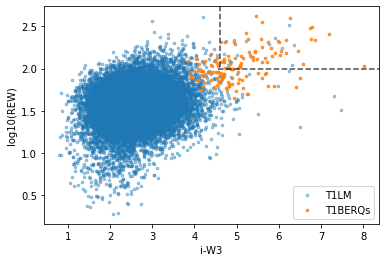

In [5]:
# Boundary of T1BERQs
Intersection =loadmat('../IsoSurf/Intersection.mat')
P_intresection = Intersection["P_intersection"]
n = Intersection["n"]
nX0 = Intersection["plane"]

data0 = np.array(list(zip(iW3_0, rew_0, kt80_0)))
data, m, r = erqScaling.MinMaxScaler(data_0)

maskERQH17 = (iW3_0>=4.6) & (rew_0>=2)
maskPlane = n[0][0]*(data[:,0]-P_intresection[0][0]) + n[0][1]*(data[:,1] - P_intresection[0][1]) + n[0][2]*(data[:,2]-P_intresection[0][2]) >=0;
maskBERQ  = (maskPlane) & (bin_label_best!=0);

plt.scatter(data0[~maskBERQ,0], data0[ ~maskBERQ,1], s=7, alpha=0.4,  label='T1LM', c='C0')
# plt.scatter(iW3_0[maskERQH17], rew_0[maskERQH17], s=7, alpha=0.8, label='T1CERQ')
# plt.scatter(iW3_0[(maskBERQ) & (~maskERQH17)], rew_0[(maskBERQ) & (~maskERQH17)], s=7, alpha=0.8, label = 'T1BERQs Not T1CERQ')
plt.scatter(iW3_0[(maskBERQ)], rew_0[(maskBERQ) ], s=7, alpha=0.8, label = 'T1BERQs', c = 'C1')
plt.axvline(x=4.6, ymin=0.72, ls='--', alpha=0.7, c='k')
plt.axhline(y=2, xmin=0.52, ls='--', alpha=0.7, c='k')
plt.xlabel('i-W3')
plt.ylabel('log10(REW)')
plt.legend(loc='lower right')
plt.savefig(dir+'/3dBoundary-iw3-rew.png', dpi=200, bbox_inches='tight')
plt.show()

In [6]:
V21_sample=['165202.64+172852.3',
'082653.42+054247.3',
'J081257.15+181916.8',
'091301.33+034207.6',
'232326.17-010033.1',
'232326.17-010033.1'];

In [7]:
Serena_qsos = ['000610.67+121501.2',
'001120.22+260109.2',
'013413.22-023409.7',
'020932.15+312202.7',
'080547.66+454159.0',
'082618.04+565345.9',
'082653.42+054247.3',
'083200.20+161500.3',
'083448.48+015921.1',
'091303.90+234435.2',
'093226.93+461442.8',
'095823.14+500018.1',
'101324.53+342702.6',
'102541.78+245424.2',
'103146.53+290324.1',
'113834.68+473250.0',
'121704.70+023417.1',
'123241.73+091209.3',
'134254.45+093059.3',
'134800.13-025006.4',
'135608.32+073017.2',
'155057.71+080652.1',
'160431.55+563354.2',
'165202.64+172852.3',
'215855.10-014717.9',
'221524.00-005643.8',
'232326.17-010033.1',
'232611.97+244905.7'
];


In [8]:
my_T1BERQs = smp['sdss_name'][maskBERQ]
np.in1d(V21_sample, my_T1BERQs)

array([ True,  True, False, False,  True,  True])

In [9]:
my_T1BERQs = smp['sdss_name'][(iW3_0>=4.6)]
np.in1d(V21_sample, my_T1BERQs)

array([ True,  True, False, False,  True,  True])

In [39]:
len(Serena_qsos)

28

In [31]:
my_T1BERQs

000521.65-085345.4
000610.67+121501.2
000746.19+122223.9
001120.22+260109.2
001428.24-064721.1
002400.25+245031.9
002400.67-081110.2
004713.21+264024.7
005044.95-021217.6
005233.24-055653.5
011601.43-050503.9


In [27]:
! cp 3D-Analysis/3dBoundary-iw3-rew.png ../../erqPaper/fig 

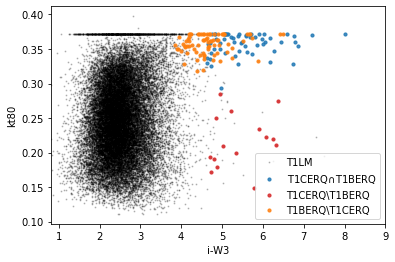

In [10]:
data = np.array(list(zip(iW3_0, rew_0, kt80_0)))
plt.scatter(iW3_0[(~maskBERQ | ~maskERQH17)], kt80_0[  (~maskBERQ | ~maskERQH17)], s=1, alpha=0.2, label='T1LM', c='k')
plt.scatter(iW3_0[maskERQH17 & maskBERQ ], kt80_0[maskERQH17 & maskBERQ], s=10, alpha=0.84, label=r'T1CERQ$\cap$T1BERQ', c='C0', edgecolors='face')
plt.scatter(iW3_0[(maskERQH17 & ~maskBERQ) ], kt80_0[(maskERQH17 & ~maskBERQ) ], s=10, alpha=0.84, label='T1CERQ\T1BERQ', c='C3', edgecolors='face')
plt.scatter(iW3_0[(~maskERQH17 & maskBERQ) ], kt80_0[(~maskERQH17 & maskBERQ) ], s=10, alpha=0.84, label='T1BERQ\T1CERQ', c='C1', edgecolors='face')
plt.xlabel('i-W3')
plt.ylabel('kt80')
plt.xlim(0.8, 9)
plt.legend(loc='lower right', prop={'size':10})
plt.savefig(dir+'/3dBoundary-iw3-kt80.png', dpi=200, bbox_inches='tight')
plt.show()

In [65]:
! cp 3D-Analysis/3dBoundary-iw3-kt80.png ../../erqPaper/fig 

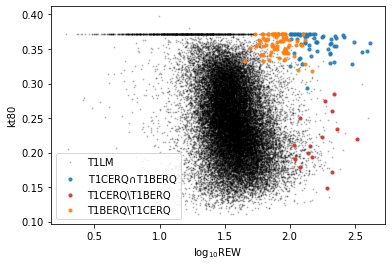

In [11]:
data = np.array(list(zip(iW3_0, rew_0, kt80_0)))
plt.scatter(rew_0[(~maskBERQ | ~maskERQH17)], kt80_0[  (~maskBERQ | ~maskERQH17)], s=1, alpha=0.2, label='T1LM', c='k')
plt.scatter(rew_0[maskERQH17 & maskBERQ ], kt80_0[maskERQH17 & maskBERQ], s=10, alpha=0.84, label=r'T1CERQ$\cap$T1BERQ', c='C0', edgecolors='face')
plt.scatter(rew_0[(maskERQH17 & ~maskBERQ) ], kt80_0[(maskERQH17 & ~maskBERQ) ], s=10, alpha=0.84, label='T1CERQ\T1BERQ', c='C3', edgecolors='face')
plt.scatter(rew_0[(~maskERQH17 & maskBERQ) ], kt80_0[(~maskERQH17 & maskBERQ) ], s=10, alpha=0.84, label='T1BERQ\T1CERQ', c='C1', edgecolors='face')
plt.xlabel(r'$\log_{10}$REW')
plt.ylabel('kt80')
plt.legend(loc='lower left', prop={'size':10})
plt.savefig(dir+'/3dBoundary-rew-kt80.png', dpi=200, bbox_inches='tight')
plt.show()

In [67]:
! cp 3D-Analysis/3dBoundary-rew-kt80.png ../../erqPaper/fig 

In [12]:
medSpec = erqMedSpec.stacker(z_dr12[maskERQH17 & ~maskBERQ], plate[maskERQH17 & ~maskBERQ], mjd[maskERQH17 & ~maskBERQ],
                             fiberid[maskERQH17 & ~maskBERQ])
np.savetxt(dir+'/med-spec-T1CERQ-not-T1BERQ.txt', medSpec)

medSpec = erqMedSpec.stacker(z_dr12[~maskERQH17 & maskBERQ], plate[~maskERQH17 & maskBERQ], mjd[~maskERQH17 & maskBERQ],
                             fiberid[~maskERQH17 & maskBERQ])
np.savetxt(dir+'/med-spec-T1BERQ-not-T1CERQ.txt', medSpec)

medSpec = erqMedSpec.stacker(z_dr12[maskERQH17], plate[maskERQH17], mjd[maskERQH17], fiberid[maskERQH17])
np.savetxt(dir+'/med-spec-T1CERQ.txt', medSpec)

medSpec = erqMedSpec.stacker(z_dr12[maskBERQ], plate[maskBERQ], mjd[maskBERQ], fiberid[maskBERQ])
np.savetxt(dir+'/med-spec-T1BERQ.txt', medSpec)



100%|██████████| 15/15 [00:03<00:00,  4.33it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|██████████| 133/133 [00:12<00:00, 10.72it/s]


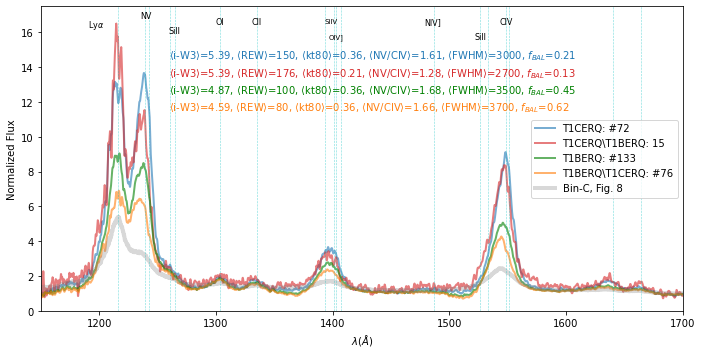

In [36]:
#ploting med spec of T1BERQs and T1CERQH17
# -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
c_ind=-1
dir='3D-Analysis'
ii=3
lambda_min = 1150; lambda_max = 1700
fig = plt.figure(figsize=(11.5,5.6))
ymax=17.5
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
plt.xlim(lambda_min,lambda_max)
plt.ylim(ymin, ymax)
x_median=lambda_min+200
# Bin C med Spec

ind = (wgrid>lambda_min) & (wgrid<lambda_max)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage

plt.ylabel('Normalized Flux')
plt.xlabel(r'$\lambda  (\AA)$')


medSpec=np.loadtxt(dir+'/med-spec-T1CERQ.txt')

SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)

plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 2., c='C0', 
                         label='T1CERQ: #%d'%np.sum(maskERQH17), alpha=0.6)    


plt.text(1260, 14.5, r'$\langle$i-W3$\rangle$=%.2f, $\langle$REW$\rangle$=%d, $\langle$kt80$\rangle$=%.2f, $\langle$NV/CIV$\rangle$=%.2f, $\langle$FWHM$\rangle$=%d, $f_{BAL}$=%.2f' %(np.median(iW3_0[maskERQH17]), 
                                                                                    np.round(np.median(10**rew_0[maskERQH17])/100,2)*100, 
                                                                         np.median(kt80_0[maskERQH17]), np.median(frat_0[maskERQH17]),
                                                                         np.round(np.median(fwhm_0[maskERQH17])/10000,2)*10000, np.sum(BI_c4[maskERQH17])/np.sum(maskERQH17)), color='C0')


medSpec=np.loadtxt(dir+'/med-spec-T1CERQ-not-T1BERQ.txt')
SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 2., c='C3', 
                         label='T1CERQ\T1BERQ: %d'%np.sum(maskERQH17 & ~maskBERQ) , alpha=0.6)

plt.text(1260, 13.5, r'$\langle$i-W3$\rangle$=%.2f, $\langle$REW$\rangle$=%d, $\langle$kt80$\rangle$=%.2f, $\langle$NV/CIV$\rangle$=%.2f, $\langle$FWHM$\rangle$=%d, $f_{BAL}$=%.2f' %(np.median(iW3_0[maskERQH17 & ~mask]),
                                                                                    np.median(10**rew_0[maskERQH17 & ~maskBERQ]), 
                                                                                     np.median(kt80_0[maskERQH17 & ~maskBERQ]), 
                                                                                    np.median(frat_0[maskERQH17 & ~maskBERQ]),
                                                                         np.round(np.median(fwhm_0[maskERQH17 & ~maskBERQ])/10000,2)*10000, np.sum(BI_c4[maskERQH17 & ~maskBERQ])/np.sum(maskERQH17 & ~maskBERQ)), color='C3')



medSpec=np.loadtxt(dir+'/med-spec-T1BERQ.txt')
SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 2., c='g', 
                         label='T1BERQ: #%d'%np.sum(maskBERQ), alpha=0.6)

plt.text(1260, 12.5, r'$\langle$i-W3$\rangle$=%.2f, $\langle$REW$\rangle$=%d, $\langle$kt80$\rangle$=%.2f, $\langle$NV/CIV$\rangle$=%.2f, $\langle$FWHM$\rangle$=%d, $f_{BAL}$=%.2f' %(np.median(iW3_0[maskBERQ]),
                                                                                    np.median(10**rew_0[maskBERQ]), 
                                                                                     np.median(kt80_0[maskBERQ]), 
                                                                                    np.median(frat_0[maskBERQ]),
                                                                         np.round(np.median(fwhm_0[maskBERQ])/10000,2)*10000, np.sum(BI_c4[maskBERQ])/np.sum(maskBERQ)), color='g')

medSpec=np.loadtxt(dir+'/med-spec-T1BERQ-not-T1CERQ.txt')
SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 2., c='C1', 
                         label='T1BERQ\T1CERQ: #%d'%np.sum((~maskERQH17) & (maskBERQ)), alpha=0.6)

plt.text(1260, 11.5, r'$\langle$i-W3$\rangle$=%.2f, $\langle$REW$\rangle$=%d, $\langle$kt80$\rangle$=%.2f, $\langle$NV/CIV$\rangle$=%.2f, $\langle$FWHM$\rangle$=%d, $f_{BAL}$=%.2f' %(np.median(iW3_0[~maskERQH17 & maskBERQ]),
                                                                                    np.median(10**rew_0[~maskERQH17 & maskBERQ]), 
                                                                                     np.median(kt80_0[~maskERQH17 & maskBERQ]), 
                                                                                    np.median(frat_0[~maskERQH17 & maskBERQ]),
                                                                         np.round(np.median(fwhm_0[~maskERQH17 & maskBERQ])/10000,2)*10000, np.sum(BI_c4[~maskERQH17 & maskBERQ])/np.sum((~maskERQH17) & (maskBERQ))), color='C1')



medSpec=np.loadtxt( dir+'/med-spec-bin-1.txt')
plt.plot(wgrid[ind],  medSpec[ind], lw = 4, c='grey', 
                 label='Bin-C, Fig. 8', alpha=0.3)
plt.legend(loc=7)
#     plt.title('Wedge: %d' %wdg)
line_db( ymax, fs, fs1, ii) 
fig_path = dir+'/3D-med-spec-T1CERQ-T1BERQ-%d-%d.png'%(lambda_min, lambda_max)

plt.savefig(fig_path, format='png', dpi=200, bbox_inches='tight')

In [37]:
! cp 3D-Analysis/3D-med-spec-T1CERQ-T1BERQ-1150-1700.png ../../erqPaper/fig